# Homework 1 Practicum
### Version 1.0 (September 06, 2024)

<font color='blue'>TODO:</font> Trevor Black (tblack20)

**Instructions:**
This notebook is intended to guide you through implement ID3 algorithm. Please answer all questions in this notebook (you will see <font color='blue'>TODO</font> annotations for where to include your answers). At the beginning of each part, we will bullet the expected deliverables for you to complete. All questions can be answered in 1-4 sentences, unless otherwise noted.

Please <font color='blue'>make a copy of this notebook in your own drive</font> before you make any edits. You can do so through File -> Save a copy in Drive

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Part I: Tennis dataset

Things to do in this part:  
1. Fill in the missing code in the DecisionTree Class.
1. Implement the evaluation function in the DecisionTree Class.
  
  

In this part, we will work with a toy dataset that records decisions on whether to play tennis depending on weather conditions. We will implement a (binary) decision tree classifier (ID3 algorithm) to predict whether to play tennis based on the weather conditions.

In [139]:
data = [['Sunny', 'Hot', 'High', 'Weak', 'No'],
       ['Sunny', 'Hot', 'High', 'Strong', 'No'],
       ['Overcast', 'Hot', 'High', 'Weak', 'Yes'],
       ['Rain', 'Mild', 'High', 'Weak', 'Yes'],
       ['Rain', 'Cool', 'Normal', 'Weak', 'Yes'],
       ['Rain', 'Cool', 'Normal', 'Strong', 'No'],
       ['Overcast', 'Cool', 'Normal', 'Strong', 'Yes'],
       ['Sunny', 'Mild', 'High', 'Weak', 'No'],
       ['Sunny', 'Cool', 'Normal', 'Weak', 'Yes'],
       ['Rain', 'Mild', 'Normal', 'Weak', 'Yes'],
       ['Sunny', 'Mild', 'Normal', 'Strong', 'Yes'],
       ['Overcast', 'Mild', 'High', 'Strong', 'Yes'],
       ['Overcast', 'Hot', 'Normal', 'Weak', 'Yes'],
       ['Rain', 'Mild', 'High', 'Strong', 'No']]
colums = ['Outlook', 'Temperature', 'Humidity', 'Wind', 'Play']
dataset = pd.DataFrame(data, columns = colums)
dataset

,Outlook,Temperature,Humidity,Wind,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


We provide the class TreeNode that represents a node in the decision tree. Each node has a feature with the corresponding splitting value, and two children nodes. The class TreeBase provides the basic structure of a decision tree, and the class DecisionTree inherits from TreeBase, which you need to complete the missing parts.

In [140]:
class TreeNode(object): # Do not modify this class
    '''
    A node class for a decision tree.
    '''
    def __init__(self, feature=None, value=None, left=None, right=None, label=None):
        self.feature = feature # feature to split on
        self.value = value # value used for splitting
        self.left = left # left child
        self.right = right # right child
        self.label = label # label for the node

The class TreeBase give you the overall structure of building a decision tree recursively (`build_tree` function), which following these essential steps:
- Create a root of the tree, and split the dataset based on the feature that gives the most information gain.
- Recursively build the left and right subtrees.
- Stop the recursion when the stopping criteria are met.

In [141]:
class TreeBase(object): # Do not modify this class
    def __init__(self, data, label, max_depth=5):
        '''
        Constructor
        Parameters:
            data: DataFrame, the data for the tree
            label: str, the label of the target
            max_depth: int, the maximum depth of the tree
        '''
        self.data = data
        self.root = None
        self.max_depth = max_depth
        self.label = label
        self.features = data.columns.drop(label)

    def select_best_feature(self, data, features):
        '''
        Select the feature with the highest information gain
        Parameters:
            data: DataFrame
            features: list of features
        Returns:
            best_feature: str
            best_value: str
        '''
        best_gain = 0

        for feature in features: #Iterate over all features
            values = data[feature].unique() #Get all unique values of the feature
            for value in values: #Iterate over all values
                gain = self.information_gain(data, feature, value) #Calculate the information gain
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_value = value

        return best_feature, best_value

    def entropy(self, data):
        raise NotImplementedError

    def information_gain(self, data, feature, value):
        raise NotImplementedError

    def predict(self, data_point):
        '''
        Predict the label for a single instance
        Parameters:
            data_point: pandas Series, with keys being the feature names
        Returns:
            label: the label of the instance
        '''
        node = self.root
        label = None
        while True:
            if node.label is not None: #Leaf node
                label = node.label
                break
            if type(node.value) == str: #Categorical feature
                go_left = data_point[node.feature] == node.value
            else: #Numerical feature
                go_left = data_point[node.feature] < node.value

            if go_left:
                node = node.left
            else:
                node = node.right
        return label

    def fit(self):
        self.root = self.build_tree(TreeNode(), self.data, self.features, 0) #Build the tree

    def build_tree(self, node, data, features, depth):
        '''
        Recursively build the decision tree
        Parameters:
            node: TreeNode, current node to be split
            data: DataFrame, the data for the tree
            features: list of features
            depth: int, the current depth of the tree
        Returns:
            node: TreeNode, the root of the built tree
        '''

        #Stop if the entropy is 0, or the depth >= max_depth, or all data points has the same feature value.
        stop = np.isclose(self.entropy(data), 0) or \
                 depth >= self.max_depth or \
                 (data.values[0] == data.values).all()
        if stop:
            node = TreeNode()
            node.label = data[self.label].mode()[0] #Get the most common label, only set label for leaf nodes
            return node

        feature, value = self.select_best_feature(data, features)
        node = TreeNode(feature=feature, value=value)
        if type(value) == str: #Categorical feature
            left_data, right_data = data[data[feature] == value], data[data[feature] != value]
        else: #Numerical feature
            left_data, right_data = data[data[feature] < value], data[data[feature] >= value]

        node.left = self.build_tree(node.left, left_data, features, depth + 1)
        node.right = self.build_tree(node.right, right_data, features, depth + 1)
        return node

    def print_tree(self):
        '''
        Print the tree
        Parameters:
            node: TreeNode, the current node
            depth: int, the current depth of the tree
        '''
        self._print_tree(self.root, 0)

    def _print_tree(self, node, depth):
        '''
        Recursively print the tree
        Parameters:
            node: TreeNode, the current node
            depth: int, the current depth of the tree
        '''
        if node is None:
            return
        if node.label is not None:
            print(" " * depth, node.label)
        else:
            if type(node.value) == str:
                print(" " * depth, node.feature, "=", node.value)
            else:
                print(" " * depth, node.feature, "<", node.value)
            self._print_tree(node.left, depth + 1)
            self._print_tree(node.right, depth + 1)


You will need to **provide the missing code** in the DecisionTree class below.

In [157]:
class DecisionTree(TreeBase):
    '''
    Binary decision tree class, inherits from TreeBase
    '''
    def __init__(self, data, label, max_depth=5):
        super(DecisionTree, self).__init__(data, label, max_depth)

    def entropy(self, data):
        '''
        Calculate the entropy of the data
        Parameters:
            data: DataFrame
        Returns:
            the entropy of the data
        '''
        # TODO: ...WRITE YOUR CODE HERE...

        # entropy (h) = sum for all x in data: -p(x)log(p(x))

        # get relevant column (Play, last column)
        plays = data.iloc[:, -1:]

        # count number of "yes" vs "no" (get frequency of all values)
        play_counts = plays.value_counts()
        
        # calculate entropy, h
        calculated_entropy = 0
        for play_count in play_counts.values:
            probability = play_count / len(plays)
            if probability > 0:
                calculated_entropy -= probability * np.log2(probability)

        return calculated_entropy


    def information_gain(self, data, feature, value):
        '''
        Calculate the information gain
        Parameters:
            data: DataFrame
            feature: the feature to split
            vavlue: the value of the feature
        Returns:
            the information gain

        '''
        # TODO: ...WRITE YOUR CODE HERE...

        entropy_total = self.entropy(data)

        # split data
        data_left = data[data[feature] <= value]
        data_right = data[data[feature] > value]

        # get split entropies
        entropy_left = self.entropy(data_left)
        entropy_right = self.entropy(data_right)

        # get weights for split entropies
        weight_left = len(data_left) / len(data)
        weight_right = len(data_right) / len(data)

        # combine split entropies by weights to get net weighted entropy
        entropy_weighted = (weight_left * entropy_left) + (weight_right * entropy_right)

        # get information gained by splitting data on feature by value
        ig = entropy_total - entropy_weighted

        return ig

We provide the code to test the decision tree on the tennis dataset. You can add more tests to check your implementation. We will not grade your additional tests, but we encourage you to do so to ensure your implementation is correct.

In [158]:
dt = DecisionTree(dataset, 'Play', 5)
data_test1 = dataset.iloc[:6]
assert np.isclose(dt.entropy(data_test1), 1.0) # Test entropy implementation
dt.fit() # Test build the tree and make sure there is no error

In [159]:
dt.print_tree() # Print the tree

 Outlook = Overcast
  Yes
  Humidity = High
   Outlook = Rain
    Wind = Strong
     No
     Yes
    No
   Wind = Strong
    Outlook = Rain
     No
     Yes
    Yes


In [160]:
sample = dataset.iloc[0]
print(sample)
print('----------')
print('prediction:', dt.predict(sample)) # Test predict function

Outlook        Sunny
Temperature      Hot
Humidity        High
Wind            Weak
Play              No
Name: 0, dtype: object
----------
prediction: No


Next, you will need to provide the code for evaluating the tree. The function take a tree model, and a dataset then output the accuracy of the decision tree on the dataset. The accuracy is defined as the number of correct predictions divided by the total number of predictions.

In [161]:
def evaluate(dt: TreeBase, dataset: pd.DataFrame):
    '''
    Evaluate the decision tree
    Parameters:
        dt: DecisionTree
        dataset: DataFrame
    Returns:
        accuracy: the accuracy of the model on the dataset
    '''
    # TODO: ...WRITE YOUR CODE HERE...

    # values we should get by running features through the model
    expected_values = dataset.iloc[:, -1:]

    # run input data through model
    inputs = dataset.iloc[:, :-1]
    correct_predictions = 0
    for i in range(len(expected_values)):
        input_feautures = inputs.iloc[i]
        predicted_value = dt.predict(input_feautures)

        # compare predicted value with expected value
        if predicted_value == expected_values.iloc[i].values[0]:
            correct_predictions += 1

    return correct_predictions / len(expected_values)

In [162]:
# test evaluate function
print('accuracy:', evaluate(dt, dataset)) # Test evaluate function

accuracy: 1.0


# Part II: The effect of tree complexity on the performance

Things to do in this part:
1. Update your DecisionTree class to handle numerical features.
1. Provide the code for training and evaluating the decision tree with various tree depths.
1. Plot the train and test accuracy.
1. Answer discussion questions.


Unlike the tennis dataset, which contains only categorical data, this part will involve working with numerical data. If you haven't already, modify your DecisionTree code to handle both categorical and numerical features. The code below generates a dataset of 1,000 samples with binary class labels. As in the previous section, we will store the dataset in a pandas DataFrame.

In [163]:
# Don't modify this cell, we will use this code to generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
# Create a pandas DataFrame for the train/test data
columns = ['feature_' + str(i) for i in range(X_train.shape[1])] + ['label']
df_train = pd.DataFrame(np.column_stack((X_train, y_train)), columns=columns)
df_test = pd.DataFrame(np.column_stack((X_test, y_test)), columns=columns)
df_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,label
0,-0.272427,-0.029398,-0.636882,1.520092,-0.239273,1.569953,0.207139,-0.751345,-0.310397,-0.693804,...,-1.482397,0.884843,0.131119,-1.607711,2.051247,-1.954593,-0.099314,-0.527984,-1.569390,1.0
1,1.603702,-0.758917,-1.073091,0.405850,-1.308684,-0.445018,-0.848905,0.906784,0.913607,0.690701,...,-0.866448,-0.797485,-0.069852,2.329718,0.380520,0.459637,0.142688,-0.214368,-0.125819,0.0
2,0.725821,-0.498031,0.551256,0.612412,1.700972,0.462312,-1.139286,-0.370698,-0.271115,0.305701,...,-0.233880,-0.201946,0.550813,0.721858,-1.250026,0.349293,0.551437,-0.387667,0.923033,1.0
3,0.946618,0.029895,-0.335516,-0.216419,-1.119250,-0.057604,0.255977,-0.363176,0.369926,-0.270270,...,0.915824,-0.778309,-0.136422,-0.011394,-0.443429,0.934655,1.612868,0.033045,-0.140276,1.0
4,-0.249894,-0.725025,-0.426571,-0.404639,1.355805,0.683565,-0.389404,0.558695,0.280236,0.384209,...,-0.907327,-0.892773,-1.224387,1.039595,1.734042,0.292149,0.107760,-0.567810,-1.197958,1.0


In [164]:
# test fitting the decision tree
dt = DecisionTree(df_train, 'label', 0)
dt.fit()

In [165]:
# test evaluate function
train_acc_value, test_acc_value = evaluate(dt, df_train), evaluate(dt, df_test)
print('Train accuracy:', train_acc_value)
print('Test accuracy:', test_acc_value)

Train accuracy: 0.5066666666666667
Test accuracy: 0.49714285714285716


Now, we will try to understand the effect of the complexity of the tree on the performance. We will use the depth of the tree as a measure of complexity. We will train the decision tree with different depths and evaluate the performance on the training and testing datasets.

In [168]:
max_depth = 3 #you can vary the depth, the larger the depth, the longer it will take to train. This is just our recommended number
train_acc, test_acc = [], [] #store the training/test accuracy for each tree depth
for tree_depth in range(max_depth + 1):
    # TODO: ...WRITE YOUR CODE HERE...
    # Fit the decision tree for each tree depth and evaluate the accuracy of on the training and test data

    tree = DecisionTree(df_train, 'label', tree_depth)
    tree.fit()

    train_acc.append(evaluate(tree, df_train))
    test_acc.append(evaluate(tree, df_test))

    print("tree", tree_depth, "done")

tree 0 done
tree 1 done
tree 2 done
tree 3 done


Plot the train and test accuracy with the corresponding depth of the tree. The x axis should be the maximum depth of the tree, and the y axis should be the accuracy. You should have two plots, one for the training accuracy and one for the testing accuracy.

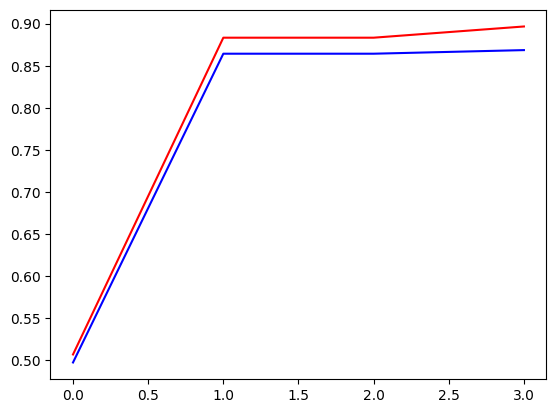

In [169]:
# TODO: ...WRITE YOUR CODE HERE...
# write the code to plot the train and test accuracy for each tree depth

plt.plot(range(len(train_acc)), train_acc, 'r')
plt.plot(range(len(test_acc)), test_acc, 'b')
plt.show()

#### Discussion questions:

What do you observe from the plot? Discuss your findings based on the train and test accuracy when increasing the depth of the tree.

<font color='blue'>
    TODO: replace this cell with your answer
</font>

The model does not increase very much after an initial jump. And that initial jump is only because it goes from making no decisions based on the data to actually interpreting the features' impact on the outcome. Increasing complexity substantially increases training times, but the return on the investement is marginal for the given data. It improves more against the training data than the test data as well. The extra depth can result in fitting the training data too much and simply memorizing the dataset rather than learning the patterns.

## Feedback

Please provide us with some feedback on how long each section or this homework overall took you. Any other feedback is also welcomed.

The analytical portion took an incredibly long time for me to complete. I didn't keep track, but definitely on the order of 10 hours, quite possibly more. So it was definitely jarring when I finished the practicum much quicker, though it felt like it took a reasonable amount of time still.

## Submit
Great work! You're all done.

Make sure to submit this Python notebook. See the homework writeup for directions.